# Thoracic Surgery Life Expectancy Classification

In [1]:
%%capture
!pip install seaborn
!pip install xgboost
!pip install dexplot

In [2]:
# loading dataset
from scipy.io import arff
import urllib.request
from io import StringIO
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import dexplot as dxp
from scipy.interpolate import interp1d

# pre-processing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold

# tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# parameter tuning
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, recall_score, precision_score

# notebook interface
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [3]:
# download dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00277/ThoraricSurgery.arff"
ftpstream = urllib.request.urlopen(url)
data, meta = arff.loadarff(StringIO(ftpstream.read().decode('utf-8')))
df = pd.DataFrame(data)

# strip vaues according to utf-8 encoding 
df = df.select_dtypes([np.object])
df = df.stack().str.decode('utf-8').unstack()

In [4]:
df.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T


## Dataset Overview

### Check that there are no missing values

In [5]:
df.notnull().describe()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
count,470,470,470,470,470,470,470,470,470,470,470,470,470,470
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,True,True,True,True,True,True,True,True,True,True,True,True,True,True
freq,470,470,470,470,470,470,470,470,470,470,470,470,470,470


The table returns True for each value found, and this table is entirely composed of True values (top: True, unique: 1), which means that there are no null values in the dataset.

Now we want to check that the parameters that should only allow binary values (corresponding to true or false), actually hold a maximim of 2 values.

In [6]:
desc = df.describe() # saving it to use it during visualisation
desc

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
count,470,470,470,470,470,470,470,470,470,470,470,470,470,470
unique,7,3,2,2,2,2,2,4,2,2,2,2,2,2
top,DGN3,PRZ1,F,F,F,T,F,OC12,F,F,F,T,F,F
freq,349,313,439,402,439,323,392,257,435,468,462,386,468,400


We can see from the description of the dataset that all parameters that should allow (T)rue or (F)alse values (columns: PRE7, PRE8, PRE9, PRE10, PRE11, PRE17, PRE19, PRE25, PRE30, PRE32, Risk1Yr), only have 2 unique values, which confirms that no missing value has been substituted with another character or string of characters (such as '?' or 'NA'). 

### Visualise data

It would be interesting to visualise how each of the pre-existing conditions, i.e. features, influences the mortality of the surgical operation. To do so, we can divide the dataset into two, according to whether the patients associated to each sample survived or not after the surgery.

In [7]:
df_surv = df.loc[df["Risk1Yr"] == 'F']
df_died = df.loc[df["Risk1Yr"] == 'T']

# list of features as it appears in the official online description of the dataset
# features that are not present in the downloaded dataset were commented out
features = dict(DGN =   'Diagnosis',
        #PRE4 =	'Forced vital capacity',
        #PRE5 =	'Volume that has been exhaled at the end of the first second of forced expiration',
        PRE6 =	'Performance status - Zubrod scale',
        PRE7 =	'Pain before surgery',
        PRE8 =  'Haemoptysis before surgery',
        PRE9 =	'Dyspnoea before surgery',
        PRE10 =	'Cough before surgery',
        PRE11 = 'Weakness before surgery',
        PRE14 = 'size of the original tumour',
        PRE17 = 'Type 2 DM - diabetes mellitus',
        PRE19 = 'MI up to 6 months',
        PRE25 = 'PAD - peripheral arterial diseases',
        PRE30 = 'Smoking',
        PRE32 = 'Asthma',
        #AGE =  'Age at surgery'
        )

Once we have the two separated datasets, we can plot a histogram for each feature, showing how many survivors and how many deceased patients compose each value of each feature, e.g. how many of the people with the feature 'PRE17' (diabetes) survived and how many died).

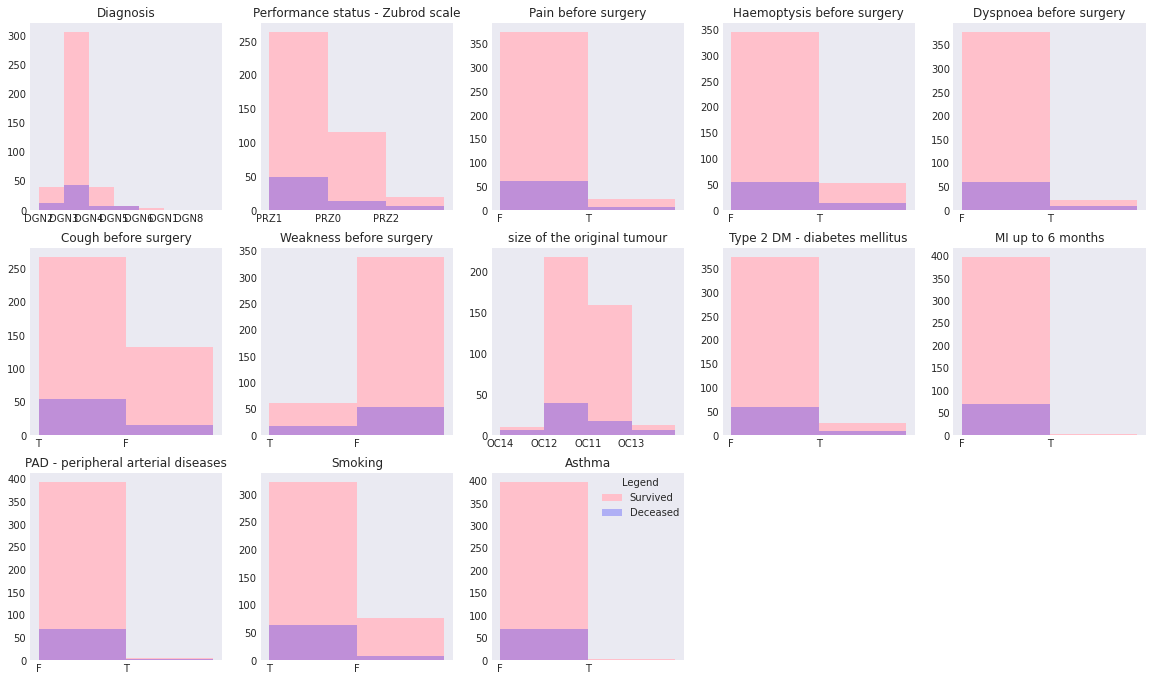

In [8]:
fig = plt.figure(1, figsize=(20.0,20.0))
c = 0
plt.style.use('seaborn-dark')

for k,v in features.items():
    c += 1
    val = list(desc[k])[1] # number of possible values for each column
    chart = fig.add_subplot(5,5,c)
    chart.title.set_text(v)
    
    bins = np.linspace(0, val, num=val+1)

    surv = df_surv[k]
    died = df_died[k]

    chart.hist(surv , bins, alpha=1, color='pink', label='survived', rwidth=6)
    chart.hist(died , bins, alpha=0.25, color='blue', label='died', rwidth=6)

    chart.set(xlabel=None)
    chart.set(ylabel=None)

chart.legend(labels=['Survived', 'Deceased'],
            loc="upper right",
            borderaxespad=0.1,
            title="Legend")

plt.show()

Unfortunately, since most features seem to be unbalanced in the number of samples for each of their values (the ratio of patients with PAD or asthma is very low, for example), normalisation needs to be applied in order to see the density of fataliites for each features.

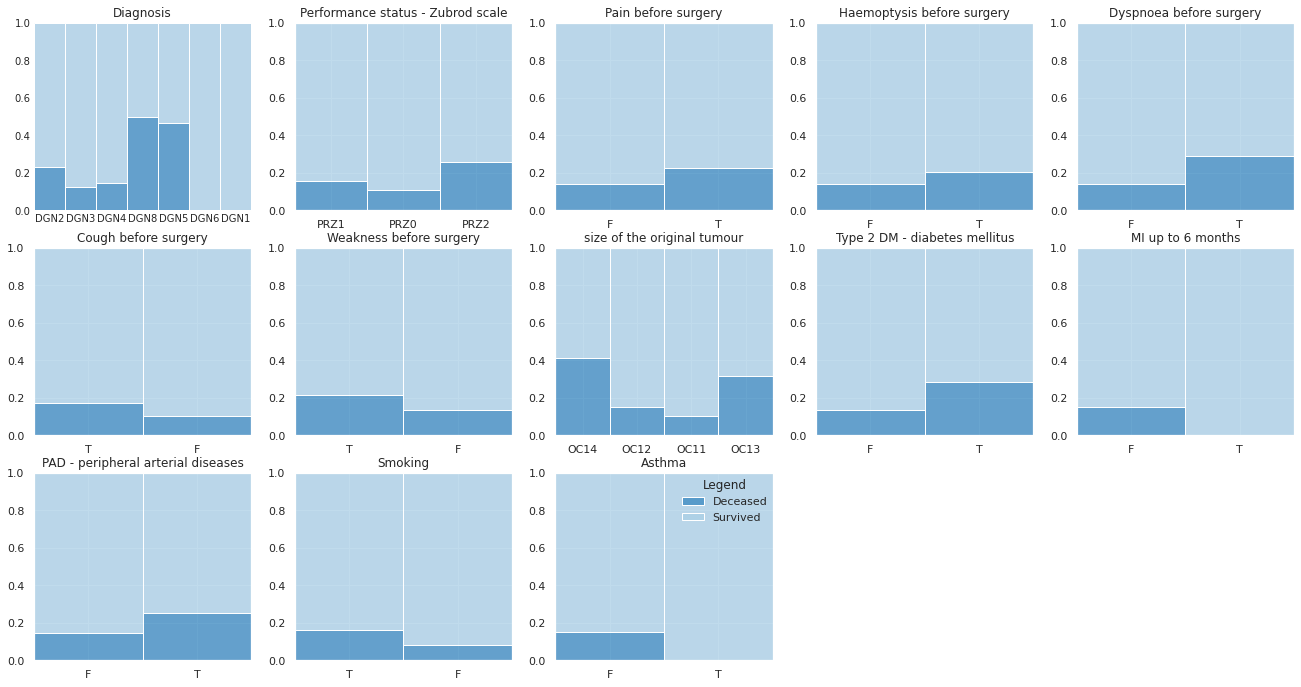

In [9]:
fig = plt.figure(1, figsize=(20.0,20.0))
c = 0
for k,v in features.items():
    c += 1
    chart = fig.add_subplot(5,5,c)
    chart.title.set_text(v)

    sns.set(font_scale=1)
    sns.histplot(df, x=k, hue="Risk1Yr", stat="probability", multiple="fill",
                            palette='Blues', legend=False)
    chart.set(xlabel=None)
    chart.set(ylabel=None)

chart.legend(labels=['Deceased', 'Survived'],
            loc="upper right",
            borderaxespad=0.1,
            title="Legend")

plt.subplots_adjust(right=1)
plt.show()

## Preprocessing

### Encoding features
In order to have all features use the same scale of values, we can encode them using OneHotEncoder()

In [10]:
df.shape

(470, 14)

In [11]:
target = df.Risk1Yr
target.shape

(470,)

In [12]:
labels = np.reshape(target.values,(470,1))
labels.shape

(470, 1)

In [13]:
ds = np.concatenate([df.iloc[:,:-1], labels], axis=1)
ds.shape

(470, 14)

In [14]:
ds = pd.DataFrame(ds)
ds.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T


In [15]:
ds.columns = ['DGN', 'PRE6', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE14', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32', 'label']
ds.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,label
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T


In [16]:
ds['label'].replace('F', 'Survived',inplace=True)
ds['label'].replace('T', 'Died',inplace=True)
ds.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,label
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,Survived
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,Survived
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,Survived
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,Survived
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,Died


In [17]:
ds_c = ds.drop(['PRE6','PRE14', 'label'], axis = 1)
ds_c.head()

,DGN,PRE7,PRE8,PRE9,PRE10,PRE11,PRE17,PRE19,PRE25,PRE30,PRE32
0,DGN2,F,F,F,T,T,F,F,F,T,F
1,DGN3,F,F,F,F,F,F,F,F,T,F
2,DGN3,F,F,F,T,F,F,F,F,T,F
3,DGN3,F,F,F,F,F,F,F,F,F,F
4,DGN3,F,T,F,T,T,F,F,F,T,F


In [18]:
ohe = OneHotEncoder()
ds_e = pd.DataFrame(ohe.fit_transform(ds_c.to_numpy()).toarray())
ds_e.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [19]:
ds_e['27'] = [int(v[-1]) for v in ds['PRE6']]
ds_e['28'] = [int(v[-2:]) for v in ds['PRE14']]
ds_e.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1,14
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,12
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1,11
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,11
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2,11


### Shuffle and split data into features X and target y.

In [31]:
X = ds_e
y = ds.label

## Algorithm Evaluations

In [32]:
# splitting train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

### Define the baselines

In [33]:
rs = 5

In [34]:
%%capture
models = [LogisticRegression(random_state=rs),
          MultinomialNB(),
          KNeighborsClassifier(),
          SVC(random_state=rs),
          LinearSVC(random_state=rs),
          DecisionTreeClassifier(random_state=rs),
          RandomForestClassifier(random_state=rs),
          GradientBoostingClassifier(random_state=rs),
          XGBClassifier(random_state=rs)]

model = []
mean = []
std = []
mins = []
maxs = []

for m in models:
    cross = cross_val_score(m, X_train, y_train, cv=5)
    model.append(type(m).__name__)
    mean.append(cross.mean())
    std.append(cross.std())
    mins.append(min(cross))
    maxs.append(max(cross))

In [35]:
result = pd.DataFrame({"Model":model, "acc_mean":mean, "STD":std, "min":mins, "max":maxs})
result.sort_values("acc_mean", ascending=False)

,Model,acc_mean,STD,min,max
3,SVC,0.851096,0.005221,0.848485,0.861538
2,KNeighborsClassifier,0.845035,0.010677,0.833333,0.861538
0,LogisticRegression,0.838928,0.006891,0.833333,0.848485
1,MultinomialNB,0.835851,0.011520,0.818182,0.848485
4,LinearSVC,0.835851,0.006395,0.830769,0.848485
6,RandomForestClassifier,0.832914,0.024861,0.803030,0.863636
7,GradientBoostingClassifier,0.820746,0.023730,0.787879,0.848485
8,XGBClassifier,0.820746,0.019480,0.787879,0.846154
5,DecisionTreeClassifier,0.793473,0.030387,0.757576,0.846154


### Improve parameters of the best performing models

In [36]:
# creating pipeline
pipeline = Pipeline([('classifier', SVC(random_state=0))])    # SVC is a dummy
                                                # actual classifiers defined in the parameter grid

In [37]:
# defining parameter ranges
params = [{'classifier' : [LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)],
            'classifier__penalty' : ['l1', 'l2', 'elasticnet'],
            'classifier__dual' : [True, False],
            'classifier__tol' : list(np.arange(0.0001,0.001,0.0001)),
            'classifier__C' : np.logspace(-4, 4, 20),
            'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
        {'classifier': [SVC(probability=True)],
            'classifier__C': [0.1, 1, 10, 100, 1000], 
            'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'classifier__kernel': ['rbf']},
        {'classifier': [LinearSVC()],
            'classifier__penalty' : ['l1', 'l2', 'elasticnet'],
            'classifier__dual' : [True, False],
            'classifier__tol' : list(np.arange(0.0001,0.001,0.0001)),
            'classifier__C' : np.logspace(-4, 4, 20),
            'classifier__loss' : ['hinge', 'squared_hinge']}]

In [38]:
# grid search
grid = GridSearchCV(pipeline, param_grid=params, refit = True, verbose = 3, n_jobs = -1,
                    cv=KFold(5, random_state=0, shuffle=True)) 

In [44]:
%%capture
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 7585 candidates, totalling 37925 fits


KeyboardInterrupt: 

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_score_

## Test Results

In [192]:
# predicting over test set with the best performing classifier
y_pred = grid.predict(X_test)

[Text(0.5, 12.5, 'predicted'), Text(30.5, 0.5, 'actual')]

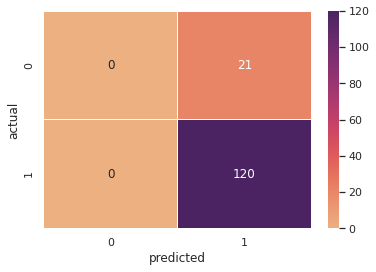

In [193]:
# plotting confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1)
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare')
matrix.set(xlabel='predicted', ylabel='actual')

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.85      1.00      0.92       120

    accuracy                           0.85       141
   macro avg       0.43      0.50      0.46       141
weighted avg       0.72      0.85      0.78       141



Although the model has an accuracy of approximately 0.85, it has the peculiarity of classifying all patients as survivors, which in a practical context would mean that 21 out of the 141 patients would die unexpectedly. This might be due to the very limited amount of fatalities in the training set.

Perhaps, the percentage associated to the probability of each patient dying could give us more insights than the binary classification alone. 

In [61]:
# predicting probabilities over test set
y_pred_prob = grid.predict_proba(X_test)

In [62]:
%%capture
i = np.argsort(y_pred_prob[:,0])[::-1]
prob = y_pred_prob[i][:,0]
test_labels = y_test.iloc[i].tolist()
list(zip(prob, test_labels))

For further analysis, we can visualise on a histogram where the fatalities are placed along an x axis representing the probability assigned to each of these cases. Ideally, the histogram should be skewed towards the left, since we would like most fatalities to be towards a higher assigned probability of death.

We can also plot the survivors on the same graph, expecting an opposite skew, as we would like most survivors to be on the low death probability spectrum.

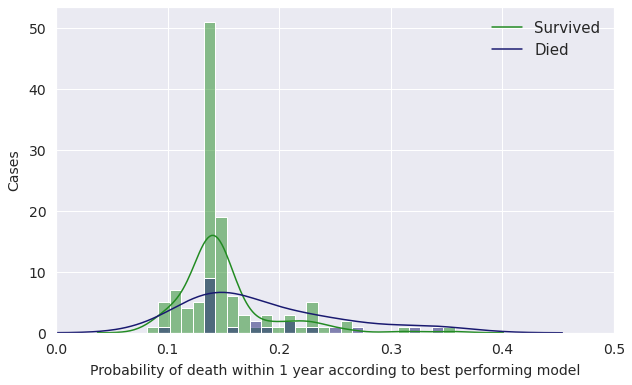

In [92]:
plt.figure(figsize=(10, 6))

plt.ylabel('Cases', fontsize=14, labelpad=7.5)
plt.xlabel('Probability of death within 1 year according to best performing model', fontsize=14, labelpad=7.5)

plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

plt.xlim(0,0.5)

bins = np.linspace(0, 0.5, 50)

sns.kdeplot(data=y_pred_prob[y_test == 1.0][:,0], color='forestgreen')
sns.kdeplot(data=y_pred_prob[y_test == 0.0][:,0], color='midnightblue')
sns.histplot(data=y_pred_prob[y_test == 1.0][:,0], bins=bins, color='forestgreen', alpha=0.5)
sns.histplot(data=y_pred_prob[y_test == 0.0][:,0], bins=bins, color='midnightblue', alpha=0.5)

plt.legend(labels=['Survived', 'Died'], fontsize=15)

plt.show()


The skew of the survivor distribution appears to the right as expected. However, the skew of the fatality distribution is not as pronounced. Nonetheless, the kde lines seem to suggest that above a certain percentage (around 0.85, varying according to the smoothing level), the fatalities augment in proportion, compared to the cases of survival (visually represented by the green line falling below the blue one).

A problem encountered so far, in addition to the unbalanced dataset over-representing survivors, is that the classifier develops the strategy of classifying every sample with the most common label. Since this strategy is developed with the purpose of optimising the accuracy, perhaps changing the scoring function to something else could provide better results.

Also, although numerically indifferent in the current system, in a practical environment, false positives and false negatives should have different 'weights' as turning misclassified fatalities (classifies as survivors) into predicted deaths could potentially save lives, while turning misclassifies survivors (classifies as likely to die) into predicted survivors could perhaps save resources spent on additional unnencessary treatment on someone who was thought to be in life danger, while they were not.

Changing the weights and the scoring function could help us find a balance between the lifes saved and the resources employed.

## Ablation study
(How the system behaves when changing the weights and the scoring function)

In [76]:
def scoring_function(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)    # finding a balance between deaths recall
            + f1_score(y_true, y_pred, pos_label=1)     # and overall accuracy

In [77]:
weights_d = np.arange(1,8,0.5) # weights to be applied in the gridsearch

In [78]:
params_SVC = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

In [86]:
%%capture
conf = []
for weight_d in weights_d:
     grid_SVC = GridSearchCV(SVC(probability=True, class_weight={0.0:weight_d, 1.0:1}),
                                   param_grid=params_SVC, refit = True, verbose = 1,
                                   cv=KFold(5, random_state=0, shuffle=True),
                                   scoring=make_scorer(scoring_function))
     grid_SVC.fit(X_train, y_train)
     y_pred = grid_SVC.predict(X_test)
     y_pred_prob = grid_SVC.predict_proba(X_test)
     conf.append(confusion_matrix(y_test, y_pred))

We can now plot the amount of correct/incorrect predictions to analyse their canges depending on the weiht assigned to the fatality class.

In [80]:
conf=np.array(conf)
true_died = conf[:,0,0]
true_surv = conf[:,1,1]
false_died = conf[:,1,0]
false_surv = conf[:,0,1]

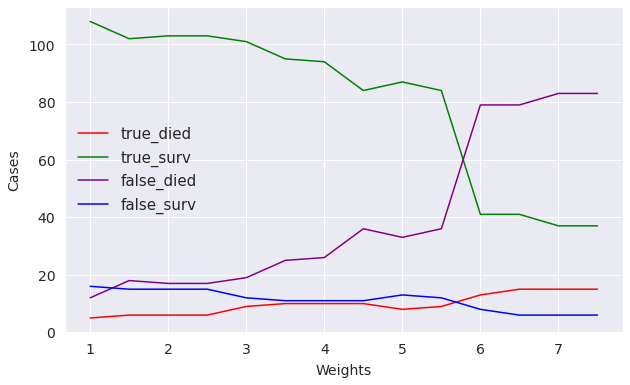

In [140]:
plt.figure(figsize=(10, 6))

plt.ylabel('Cases', fontsize=14, labelpad=7.5)
plt.xlabel('Weights', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.lineplot(weights_d, true_died, color='red')
sns.lineplot(weights_d, true_surv, color='green')
sns.lineplot(weights_d, false_died, color='purple')
sns.lineplot(weights_d, false_surv, color='blue')

plt.legend(labels=['true_died', 'true_surv', 'false_died', 'false_surv'], fontsize=15)

plt.show()


From the graph, it seems that as the weight assigned to the death class increases, an increasing number of samples are assigned to the corresponding class, although the number of wrong classifications (purple line) is always higher than that of correct ones (red line).  

In a practical setting, the red line (true_died) would represent people who are correctly classified as being in life danger and whose lives could be saved if predicted on time.

The purple line (false_died) would represent people who are falsely predicted of being at risk of dying (or already dead, in the actual context of the test set). The health system could invest resources to try and save these patients althought they are not in life danger.

These are only some of the issues the healthcare provider could encounter when using this model and a better insight of the specific institution would help pointing out other weaknesses of this system.

Depending on the resources allocated to te healthcare provider and the amount of unpredicted deaths they are willing to accept, the weight of the class should be adjusted accordingly. As an example, we could select a weight of 3, before the false_died spikes up leaving true_death almost constant and visualise the results.

In [93]:
weight_d = 3
grid_SVC = GridSearchCV(SVC(probability=True, class_weight={0.0:weight_d, 1.0:1}),
                        param_grid=params_SVC, refit = True, verbose = 1,
                        cv=KFold(5, random_state=0, shuffle=True),
                        scoring=make_scorer(scoring_function))
grid_SVC.fit(X_train, y_train)
y_pred = grid_SVC.predict(X_test)
y_pred_prob = grid_SVC.predict_proba(X_test)
conf.append(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Text(0.5, 12.5, 'predicted'), Text(30.5, 0.5, 'actual')]

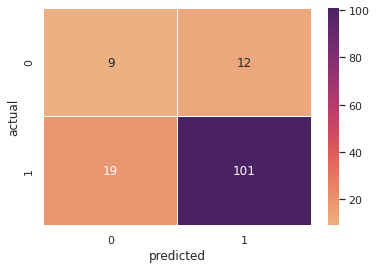

In [94]:
# plotting confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1)
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare')
matrix.set(xlabel='predicted', ylabel='actual')

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.32      0.43      0.37        21
         1.0       0.89      0.84      0.87       120

    accuracy                           0.78       141
   macro avg       0.61      0.64      0.62       141
weighted avg       0.81      0.78      0.79       141



In this case, 12 deaths could not be predicted and 19 were falsely predicted, but 9 were correctly detected.

Of course, in order to make accurate predictions the dataset would need to be heavily expanded, both in terms of number of samples and in the number of features, since other conditions, pre-existing or related to the illness, and other metrics such as age and gender, could all contribute to a better classification system.